In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns_context = "notebook"
sns.set_theme(context=sns_context, style="ticks")
# proper labeling of plots
from matplotlib.ticker import EngFormatter
## define a Q() function
from scipy import special
import random

In [3]:
def Q(x):
    """Gaussian error function"""
    return 0.5*special.erfc(x/np.sqrt(2))

In [4]:
def half_sine_pulse(fsT):
    """Generate a pulse that is shaped like a half cycle of a sinusoid

    Inputs:
    fsT: number of samples per symbol period

    Returns:
    Numpy array with fsT+1 samples (the sample at time t=T is included)
    """

    tt = np.arange(fsT+1) / fsT
    return np.sqrt(2/fsT) * np.sin(np.pi*tt)


In [5]:
def pulse_shape(symbols, pulse, fsT):
    """Generate a pulse-shaped QAM signal

    Inputs:
    symbols: a sequence of information symbols; rate 1/T
    pulse: sampled pulse shape; rate fsT/T
    fsT: samples per symbol period

    Returns:
    Numpy array with fsT*(len(symbols) - 1) + len(pulse)  samples
    """
    # step 1: upsample the symbol sequence
    up_symbols = np.zeros(fsT * (len(symbols) - 1) + 1, dtype=symbols.dtype)
    up_symbols[::fsT] = symbols

    # step 2: filter
    return np.convolve(up_symbols, pulse)

In [6]:
def random_symbols(A, N):
    """generate random symbols from the constellation A

    Inputs:
    A: np.ndarray of symbols in constellation, e.g., A = np.array([1, -1]) for BPSK
    N: number of random symbols to produce

    Returns:
    Numpy array of length N
    """
    return A[np.random.randint(len(A), size=N)]

In [7]:
def MPE_decision_rule(Z, A):
    """Decide which symbol was most likely transmitted

    This function examines matched filter outputs (in vector Z) and for each element of Z selects the symbol
    from constellation A that is closest.

    Inputs:
    Z - Vector of matched filter outputs
    A - Constellation

    Returns:
    Numpy array of the same length as Z
    """
    dec = np.empty_like(Z)
    for n in range(len(Z)):
        this_Z = Z[n]
        ind = np.argmin(np.abs(A-this_Z))
        dec[n] = A[ind]

    return dec

In [8]:
def ser_qpsk_exact(x):
    exact_qpsk_ser = 2*Q(np.sqrt(x)) - Q(np.sqrt(x))**2
    return exact_qpsk_ser

#### Nearest Neighbor for 16APSK

$$
    \text{Pr}\{\text{symbol error}\} \approx 3/2 \cdot Q(\sqrt{\frac{\eta E_s}{8 N_0}})
$$
in terms of $E_s/N_0$.

In [9]:
def ser_apsk_16_nn(x):
    # Nearest neighbor approximation for 16apsk 
    nn_16apsk = (3/2)*Q(np.sqrt(x))
    return nn_16apsk

In [10]:
# Problem 2
Es = 1
# Define a normalized QPSK constellation
qpsk_const = np.array([np.exp(1j*np.pi/4), np.exp(1j*3*np.pi/4), np.exp(1j*5*np.pi/4), np.exp(1j*7*np.pi/4)])
num_symbols = 1024
qpsk_sym = random_symbols(qpsk_const, num_symbols)
avg_sym_energy = 1/num_symbols * np.sum(np.abs(qpsk_sym)**2)
print("average symbol energy before pulse shaping: ", avg_sym_energy)
fsT = 16

# Pulse shaping
pp = half_sine_pulse(fsT)  
mag_pp = np.sum(np.abs(pp)**2)
print("The energy of the pulse has to be one", mag_pp)
ss = pulse_shape(qpsk_sym, pp, fsT)
print("average symbol energy after pulse shaping: ", 1/num_symbols * np.sum(np.abs(ss)**2))



average symbol energy before pulse shaping:  1.0
The energy of the pulse has to be one 1.0
average symbol energy after pulse shaping:  1.0


In [240]:

def montecarlo_qpsk(SNR_LINEAR,MAX_BURSTS=2000,MAX_ERRORS=100):
    N_bursts = 0
    N_errors = 0
    while N_bursts < MAX_BURSTS and N_errors < MAX_ERRORS:
        noise_var = Es/SNR_LINEAR
        sigma = np.sqrt(noise_var/2)
        noise = sigma*(np.random.randn(len(ss)) + 1j*np.random.randn(len(ss)))
        # channel (add gaussian noise)
        tx_data = ss + noise
        # Receiver
        rx_data = tx_data
        # Apply matched filter
        mf = np.flip(pp)
        mf_out = np.convolve(rx_data, mf)
        Z = mf_out[fsT:-fsT:fsT]
        dec = MPE_decision_rule(Z, qpsk_const)

       # Evaluate simulation errors
        N_bursts += 1
        N_errors += np.sum(np.not_equal(dec, qpsk_sym))

    # Simulated SER
    M = num_symbols * N_bursts  # Total symbols transmitted
    ser_sim =  N_errors/M
    # print(N_errors)
    # Calculate 95% confidence interval for the simulated SER
    z_c = 1.96  # 95% confidence level
    if N_errors > 0:
        s_c = z_c * np.sqrt((ser_sim * (1 - ser_sim)) / M)
    else:
        s_c = 0  # No errors, no confidence interval needed

      # Eye Diagram plot of real part only
    for n in range(len(ss)//(2*fsT)):
        plt.plot(np.arange(2*fsT)/fsT, np.real(mf_out[n*2*fsT:(n+1)*2*fsT]), 'b')

    plt.grid()
    plt.show()

    # Eye Diagram plot of imaginary part only
    for n in range(len(ss)//(2*fsT)):
        plt.plot(np.arange(2*fsT)/fsT, np.imag(mf_out[n*2*fsT:(n+1)*2*fsT]), 'r')

    plt.grid()
    plt.show()

    plt.plot(np.real(Z), np.imag(Z), 'o')

    plt.axis('equal')
    plt.xlabel('I')
    plt.ylabel('Q')

    # decision boundaries
    plt.axhline(0, color='r', ls='--')
    plt.axvline(0, color='r', ls='--')


    plt.show()
        
    return ser_sim, s_c

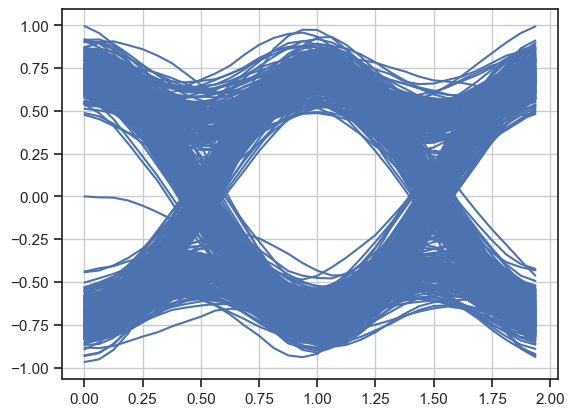

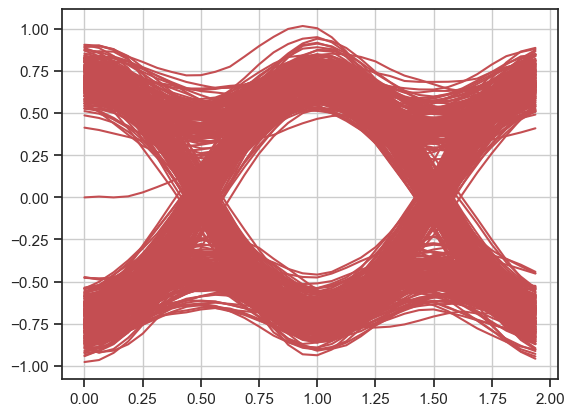

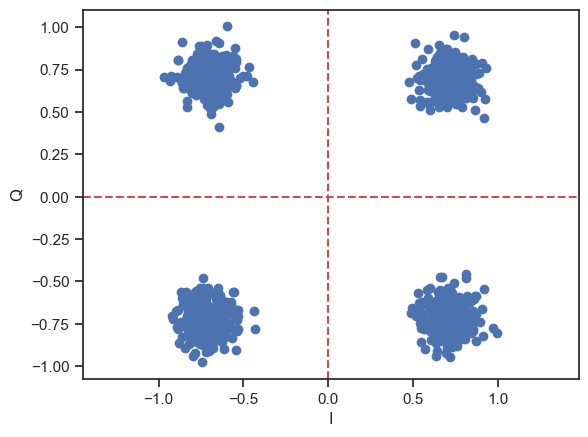

0.0


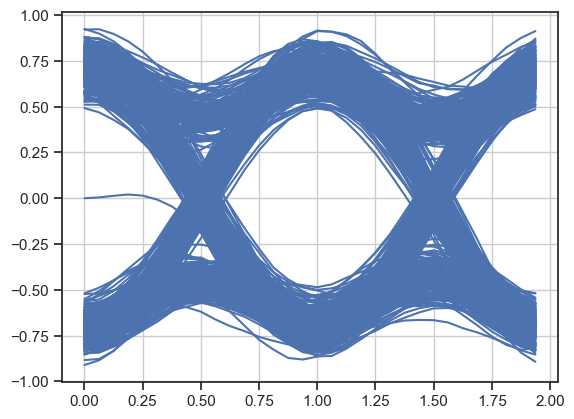

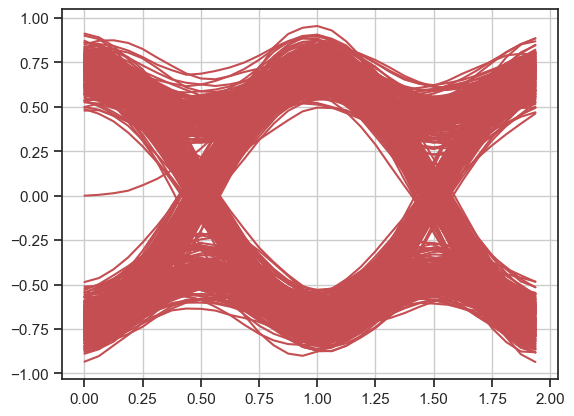

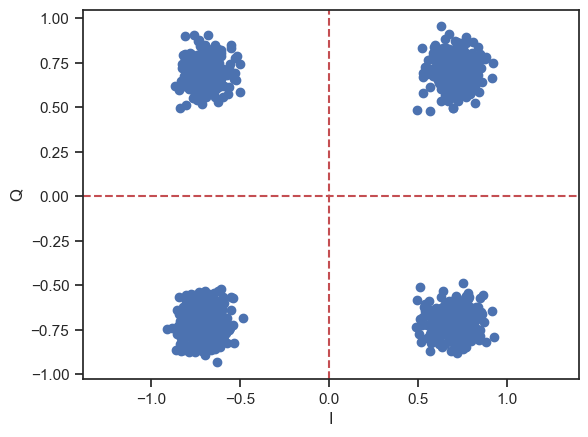

0.0


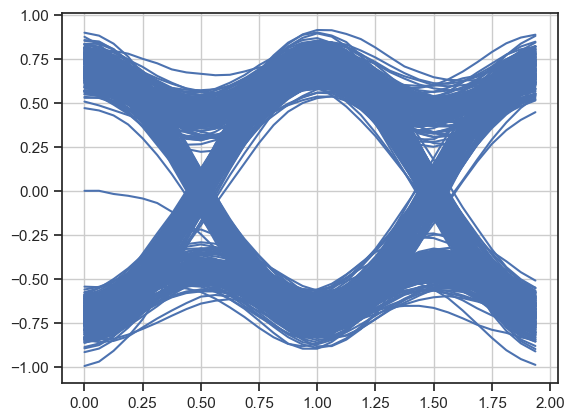

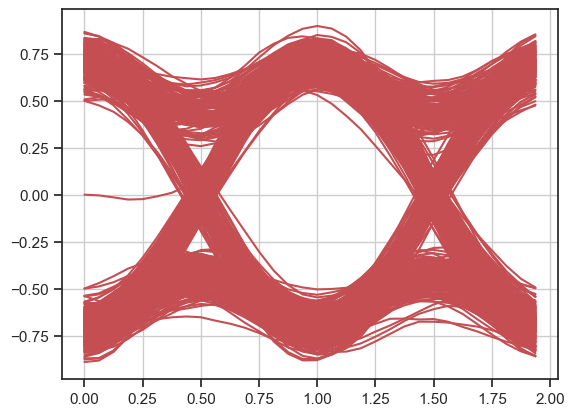

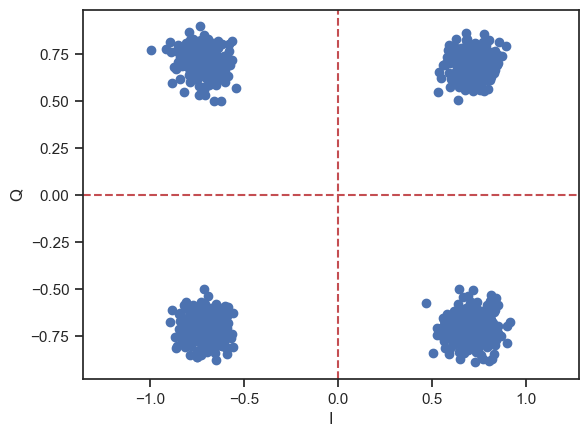

0.0


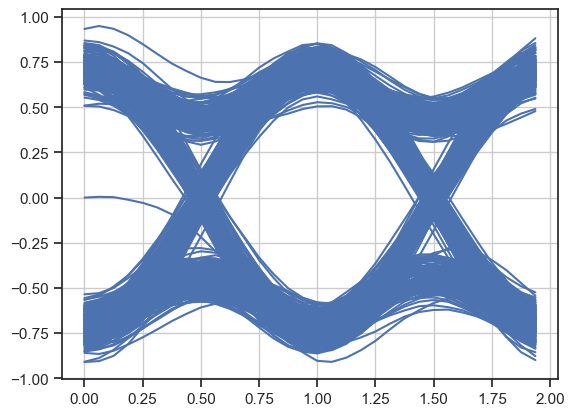

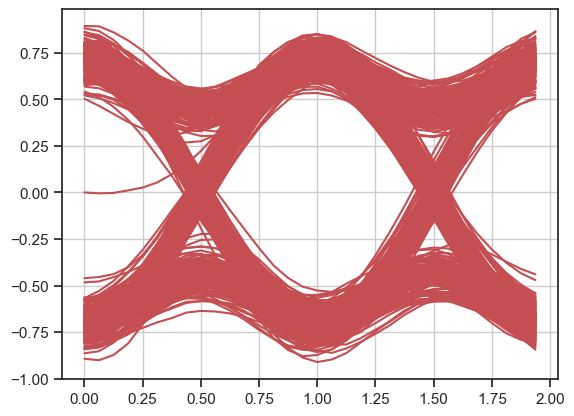

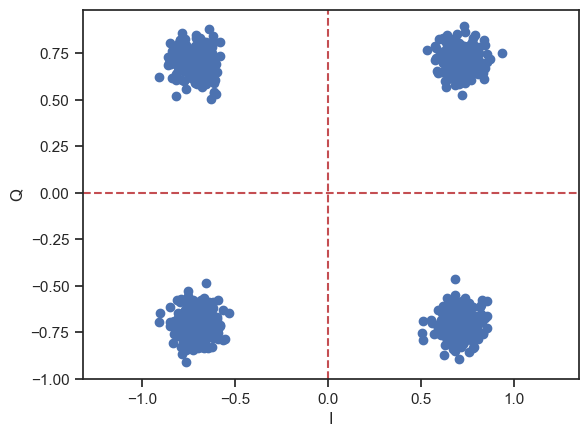

0.0


In [241]:
# Arrays to store results
ser_simulated = []
ser_exact = []
confidence_intervals = []
snr = []
for snr_db in range(18,22,1):
    snr_linear = 10**(snr_db/10)
    ser_theory = ser_qpsk_exact(snr_linear)
    ser_sim, s_c = montecarlo_qpsk(snr_linear)
    print(ser_sim)
    ser_exact.append(ser_theory)
    ser_simulated.append(ser_sim)
    confidence_intervals.append(s_c)
    snr.append(snr_db)
    

In [249]:
ser_simulated

[np.float64(0.0)]

In [250]:
ser_exact

[np.float64(2.798055618599648e-10)]

/var/folders/7y/zn2wsyn90v971fl99gkffxdh0000gn/T/ipykernel_87545/2491082010.py:4: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "ko" (-> marker='o'). The keyword argument will take precedence.
  plt.plot(snr, ser_simulated, 'ko', marker='o', linestyle='-')


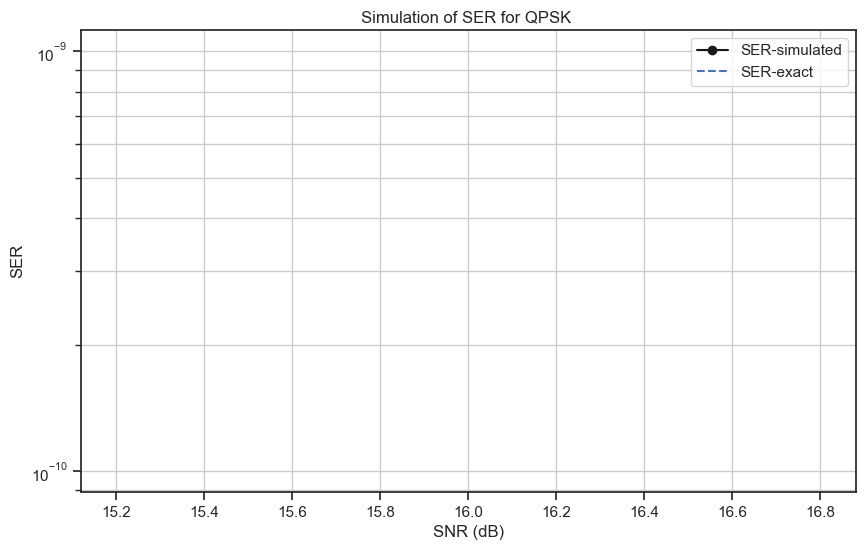

In [251]:
plt.figure(figsize=(10, 6))

# Plot SNR vs errors, with a logarithmic scale for the errors
plt.plot(snr, ser_simulated, 'ko', marker='o', linestyle='-')
plt.plot(snr, ser_exact, 'b', linestyle='--')

# Add error bars to show confidence intervals
lower_bound = [ser - ci for ser, ci in zip(ser_simulated, confidence_intervals)]
upper_bound = [ser + ci for ser, ci in zip(ser_simulated, confidence_intervals)]
plt.errorbar(snr, ser_simulated, yerr=confidence_intervals, fmt='o', capsize=5)

# Set the y-axis to a logarithmic scale
plt.yscale('log')

# Add labels and title
plt.xlabel('SNR (dB)')
plt.ylabel('SER')
plt.title('Simulation of SER for QPSK ')
plt.grid(True, which="both")  # Add gridlines for both major and minor ticks
plt.legend(['SER-simulated','SER-exact' ])

# Show the plot
plt.show()

In [87]:
outer_const_8 = 2.5*np.array([np.exp(1j*np.pi/12),np.exp(1j*5*np.pi/12),np.exp(1j*7*np.pi/12),
np.exp(1j*11*np.pi/12),np.exp(1j*13*np.pi/12),np.exp(1j*17*np.pi/12),np.exp(1j*19*np.pi/12),
np.exp(1j*23*np.pi/12)])
np.real(outer_const_8)

array([ 2.41481457,  0.64704761, -0.64704761, -2.41481457, -2.41481457,
       -0.64704761,  0.64704761,  2.41481457])

In [71]:
def generate_16APSK_constellation(gamma):
    # Solve for R1 and R2 based on the average energy constraint
    # The equation is (54 * R1^2)/ 16 = Es
    Es = 1
    
    R1 = np.sqrt((16/54)*Es)
    R2 = gamma*R1

    # The inner ring has 4 points
    inner_const = R1*np.array([np.exp(1j*np.pi/4), np.exp(1j*3*np.pi/4), np.exp(1j*5*np.pi/4), 
    np.exp(1j*7*np.pi/4)])
    # The outer ring has 4 points located at same angle as the 4 inner points
    outer_const_4 = R2*np.array([np.exp(1j*np.pi/4), np.exp(1j*3*np.pi/4), np.exp(1j*5*np.pi/4), 
    np.exp(1j*7*np.pi/4)])
    # The outer ring has 8 additional points 
    outer_const_8 = R2*np.array([np.exp(1j*np.pi/12),np.exp(1j*5*np.pi/12),np.exp(1j*7*np.pi/12),
    np.exp(1j*11*np.pi/12),np.exp(1j*13*np.pi/12),np.exp(1j*17*np.pi/12),np.exp(1j*19*np.pi/12),
    np.exp(1j*23*np.pi/12)])
    outer_const = np.concatenate((outer_const_4,outer_const_8))
    apsk16_const = np.concatenate((inner_const,outer_const))
    x_inner = np.real(inner_const)
    y_inner = np.imag(inner_const)

    x_outer = np.real(outer_const)
    y_outer = np.imag(outer_const)

    return x_inner, y_inner, x_outer, y_outer, apsk16_const, R1, R2
gamma = 2.5
x_inner, y_inner, x_outer, y_outer, apsk16_const,R1, R2 = generate_16APSK_constellation(gamma)
apsk16_const


array([ 0.38490018+0.38490018j, -0.38490018+0.38490018j,
       -0.38490018-0.38490018j,  0.38490018-0.38490018j,
        0.96225045+0.96225045j, -0.96225045+0.96225045j,
       -0.96225045-0.96225045j,  0.96225045-0.96225045j,
        1.31445856+0.35220811j,  0.35220811+1.31445856j,
       -0.35220811+1.31445856j, -1.31445856+0.35220811j,
       -1.31445856-0.35220811j, -0.35220811-1.31445856j,
        0.35220811-1.31445856j,  1.31445856-0.35220811j])

In [72]:
R1

np.float64(0.5443310539518174)

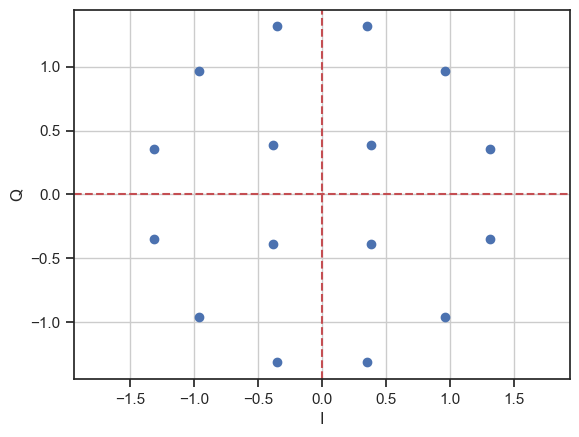

In [218]:
outer_const_4 = R2*np.array([np.exp(1j*np.pi/4), np.exp(1j*3*np.pi/4), np.exp(1j*5*np.pi/4), 
    np.exp(1j*7*np.pi/4)])
outer_const_8 = R2*np.array([np.exp(1j*np.pi/12),np.exp(1j*5*np.pi/12),np.exp(1j*7*np.pi/12),
    np.exp(1j*11*np.pi/12),np.exp(1j*13*np.pi/12),np.exp(1j*17*np.pi/12),np.exp(1j*19*np.pi/12),
    np.exp(1j*23*np.pi/12)])
inner_const = R1*np.array([np.exp(1j*np.pi/4), np.exp(1j*3*np.pi/4), np.exp(1j*5*np.pi/4), 
    np.exp(1j*7*np.pi/4)])
outer_const = np.concatenate((outer_const_4,outer_const_8))
apsk16_const = np.concatenate((inner_const,outer_const))
# apsk16_const = inner_const
plt.plot(np.real(apsk16_const), np.imag(apsk16_const), 'o')
plt.grid()

plt.axis('equal')
plt.xlabel('I')
plt.ylabel('Q')

# decision boundaries
plt.axhline(0, color='r', ls='--')
plt.axvline(0, color='r', ls='--')


plt.show()

In [219]:
outer_const_4

array([ 0.96225045+0.96225045j, -0.96225045+0.96225045j,
       -0.96225045-0.96225045j,  0.96225045-0.96225045j])

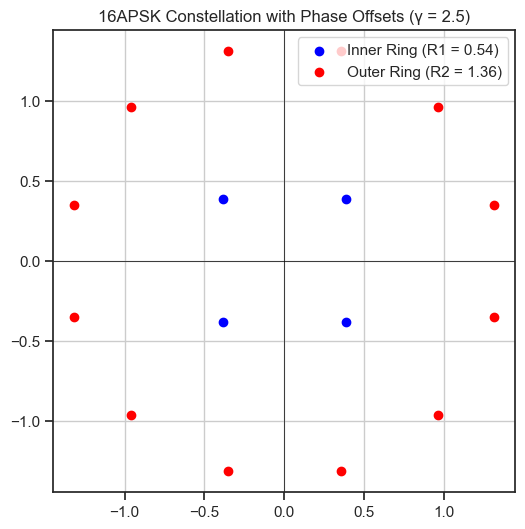

In [220]:
plt.figure(figsize=(6, 6))
plt.scatter(x_inner, y_inner, color='blue', label=f"Inner Ring (R1 = {R1:.2f})")
plt.scatter(x_outer, y_outer, color='red', label=f"Outer Ring (R2 = {R2:.2f})")
plt.axhline(0, color='black', linewidth=0.5)
plt.axvline(0, color='black', linewidth=0.5)

plt.title('16APSK Constellation with Phase Offsets (γ = 2.5)')
plt.legend()
plt.grid(True)
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

In [221]:
print(apsk16_const)

[ 0.38490018+0.38490018j -0.38490018+0.38490018j -0.38490018-0.38490018j
  0.38490018-0.38490018j  0.96225045+0.96225045j -0.96225045+0.96225045j
 -0.96225045-0.96225045j  0.96225045-0.96225045j  1.31445856+0.35220811j
  0.35220811+1.31445856j -0.35220811+1.31445856j -1.31445856+0.35220811j
 -1.31445856-0.35220811j -0.35220811-1.31445856j  0.35220811-1.31445856j
  1.31445856-0.35220811j]


In [222]:
Es = 1
# Define a normalized 16PSK constellation
apsk16_const = apsk16_const
norm = np.mean(np.abs(apsk16_const)**2)
apsk16_const_norm = apsk16_const/np.sqrt(norm)
# print(apsk16_const_norm)
num_symbols = 1024
apsk16_sym = random_symbols(apsk16_const_norm, num_symbols)
avg_sym_energy = 1/num_symbols * np.sum(np.abs(apsk16_sym)**2)
print("average symbol energy before pulse shaping: ", avg_sym_energy)
fsT = 32

# Pulse shaping
pp = half_sine_pulse(fsT)  
mag_pp = np.sum(np.abs(pp)**2)
print("The energy of the pulse has to be one:", mag_pp)
ss = pulse_shape(apsk16_sym, pp, fsT)
print("average symbol energy after pulse shaping: ", 1/num_symbols * np.sum(np.abs(ss)**2))

average symbol energy before pulse shaping:  1.0134988132911391
The energy of the pulse has to be one: 1.0
average symbol energy after pulse shaping:  1.0134988132911391


In [237]:

def montecarlo_16apsk(SNR_LINEAR,MAX_BURSTS=10000,MAX_ERRORS=400):
    N_bursts = 0
    N_errors = 0
    while N_bursts < MAX_BURSTS and N_errors < MAX_ERRORS:
       
        noise_var = Es/SNR_LINEAR
        sigma = np.sqrt(noise_var/2)
        noise = sigma*(np.random.randn(len(ss)) + 1j*np.random.randn(len(ss)))
        # channel (add gaussian noise)
        tx_data = ss + noise
        # Receiver
        rx_data = tx_data
        # Apply matched filter
        mf = np.flip(pp)
        mf_out = np.convolve(rx_data, mf)
        Z = mf_out[fsT:-fsT:fsT]
        dec = MPE_decision_rule(Z, apsk16_const_norm)
        # print(len(dec))

       # Evaluate simulation errors
        N_bursts += 1
        N_errors += np.sum(np.not_equal(dec, apsk16_sym))
        # print(N_errors)

    # Simulated SER
    M = num_symbols * N_bursts  # Total symbols transmitted
    ser_sim =  N_errors/M
    # print(N_errors)
    # Calculate 95% confidence interval for the simulated SER
    z_c = 1.96  # 95% confidence level
    if N_errors > 0:
        s_c = z_c * np.sqrt((ser_sim * (1 - ser_sim)) / M)
    else:
        s_c = 0  # No errors, no confidence interval needed

    
    
    # Eye Diagram plot of real part only
    for n in range(len(ss)//(2*fsT)):
        plt.plot(np.arange(2*fsT)/fsT, np.real(mf_out[n*2*fsT:(n+1)*2*fsT]), 'b')

    plt.grid()
    plt.show()

    # Eye Diagram plot of imaginary part only
    for n in range(len(ss)//(2*fsT)):
        plt.plot(np.arange(2*fsT)/fsT, np.imag(mf_out[n*2*fsT:(n+1)*2*fsT]), 'r')

    plt.grid()
    plt.show()

    plt.plot(np.real(Z), np.imag(Z), 'o')

    plt.axis('equal')
    plt.xlabel('I')
    plt.ylabel('Q')

    # decision boundaries
    plt.axhline(0, color='r', ls='--')
    plt.axvline(0, color='r', ls='--')


    plt.show()
    return ser_sim, s_c

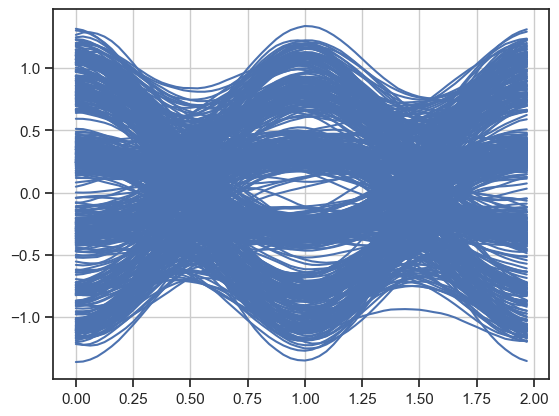

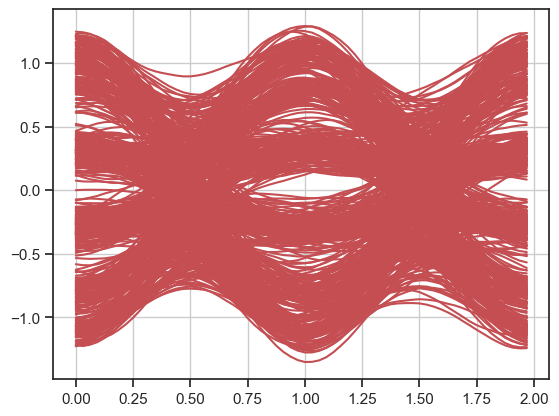

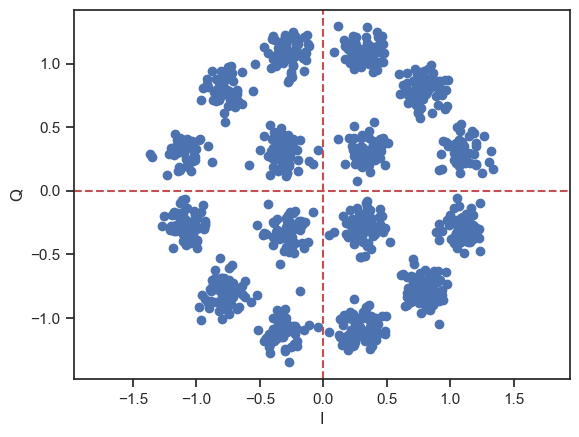

In [238]:
# Arrays to store results for 16-APSK
ser_simulated = []
ser_nn = []
confidence_intervals = []
snr = []
calc_snr = 17.5
snr_db_low = calc_snr - 5
snr_db_high = calc_snr + 4
energy_efficiency = 1.185
for snr_db in np.arange(18,19,1):
    snr_linear = 10**(snr_db/10)
    ser_theory = ser_apsk_16_nn((energy_efficiency*snr_linear)/8)
    # print(ser_theory)
    ser_sim, s_c = montecarlo_16apsk(snr_linear)
    ser_nn.append(ser_theory)
    ser_simulated.append(ser_sim)
    confidence_intervals.append(s_c)
    snr.append(snr_db)

In [225]:
ser_simulated

[np.float64(0.0010196834415584415)]

In [192]:
ser_nn

[np.float64(0.09410564954380336)]

/var/folders/7y/zn2wsyn90v971fl99gkffxdh0000gn/T/ipykernel_48712/950855430.py:4: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "ko" (-> marker='o'). The keyword argument will take precedence.
  plt.plot(snr, ser_simulated, 'ko', marker='o', linestyle='-')


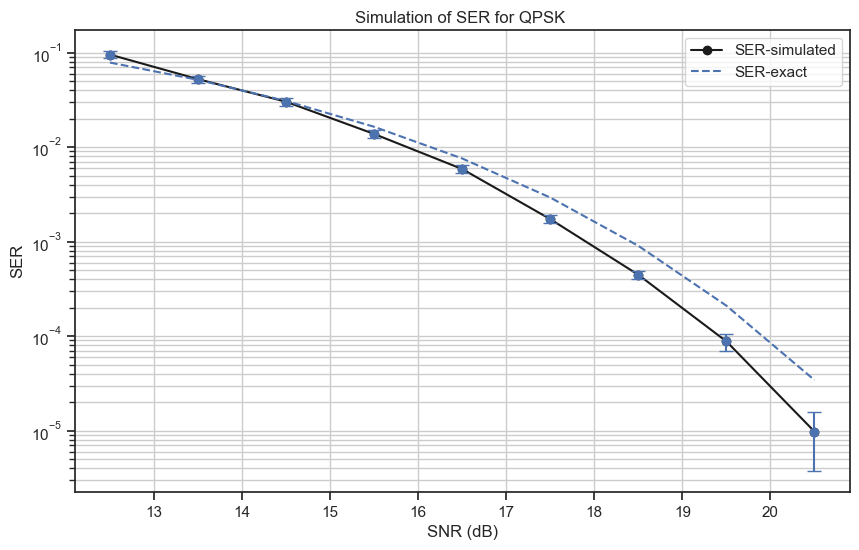

In [144]:
plt.figure(figsize=(10, 6))

# Plot SNR vs errors, with a logarithmic scale for the errors
plt.plot(snr, ser_simulated, 'ko', marker='o', linestyle='-')
plt.plot(snr, ser_nn, 'b', linestyle='--')

# Add error bars to show confidence intervals
lower_bound = [ser - ci for ser, ci in zip(ser_simulated, confidence_intervals)]
upper_bound = [ser + ci for ser, ci in zip(ser_simulated, confidence_intervals)]
plt.errorbar(snr, ser_simulated, yerr=confidence_intervals, fmt='o', capsize=5)

# Set the y-axis to a logarithmic scale
plt.yscale('log')

# Add labels and title
plt.xlabel('SNR (dB)')
plt.ylabel('SER')
plt.title('Simulation of SER for QPSK ')
plt.grid(True, which="both")  # Add gridlines for both major and minor ticks
plt.legend(['SER-simulated','SER-exact' ])

# Show the plot
plt.show()

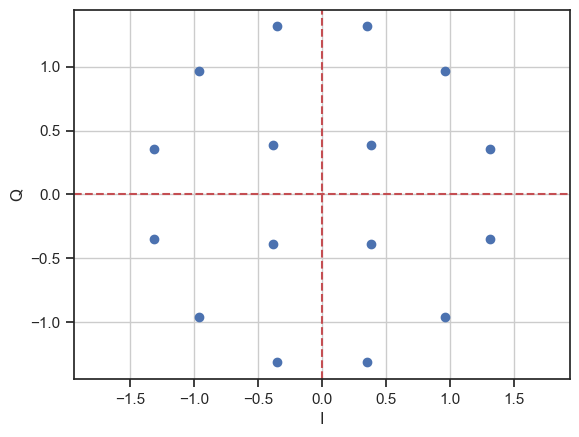

In [149]:
outer_const_4 = R2*np.array([np.exp(1j*np.pi/4), np.exp(1j*3*np.pi/4), np.exp(1j*5*np.pi/4), 
    np.exp(1j*7*np.pi/4)])
outer_const_8 = R2*np.array([np.exp(1j*np.pi/12),np.exp(1j*5*np.pi/12),np.exp(1j*7*np.pi/12),
    np.exp(1j*11*np.pi/12),np.exp(1j*13*np.pi/12),np.exp(1j*17*np.pi/12),np.exp(1j*19*np.pi/12),
    np.exp(1j*23*np.pi/12)])
inner_const = R1*np.array([np.exp(1j*np.pi/4), np.exp(1j*3*np.pi/4), np.exp(1j*5*np.pi/4), 
    np.exp(1j*7*np.pi/4)])
outer_const = np.concatenate((outer_const_4,outer_const_8))
apsk16_const = np.concatenate((inner_const,outer_const))

# apsk16_const = inner_const
plt.plot(np.real(apsk16_const), np.imag(apsk16_const), 'o')
plt.grid()

plt.axis('equal')
plt.xlabel('I')
plt.ylabel('Q')

# decision boundaries
plt.axhline(0, color='r', ls='--')
plt.axvline(0, color='r', ls='--')


plt.show()

In [187]:
Es = 1
# Define a normalized 16PSK constellation
apsk16_const = apsk16_const
norm = np.mean(np.abs(apsk16_const)**2)
apsk16_const_norm = apsk16_const/np.sqrt(norm)
apsk16 = {
    0o14: apsk16_const_norm[0],   # 1100 in binary
    0o16: apsk16_const_norm[1],   # 1110 in binary
    0o17: apsk16_const_norm[2],   # 1111 in binary
    0o15: apsk16_const_norm[3],   # 1101 in binary
    0o00: apsk16_const_norm[4],   # 0000 in binary
    0o02: apsk16_const_norm[5],   # 0010 in binary
    0o03: apsk16_const_norm[6],   # 0011 in binary
    0o01: apsk16_const_norm[7],   # 0001 in binary
    0o04: apsk16_const_norm[8],   # 0100 in binary
    0o10: apsk16_const_norm[9],   # 1000 in binary
    0o12: apsk16_const_norm[10],  # 1010 in binary
    0o06: apsk16_const_norm[11],  # 0110 in binary
    0o07: apsk16_const_norm[12],  # 0111 in binary
    0o13: apsk16_const_norm[13],  # 1011 in binary
    0o11: apsk16_const_norm[14],  # 1001 in binary
    0o05: apsk16_const_norm[15],  # 0101 in binary
}
num_symbols = 1024
bits_in = [random.getrandbits(1) for _ in range(num_symbols*int(np.log2(16)))]
apsk16_mod_data = mod_mapper(bits_in,apsk16)
avg_sym_energy = 1/num_symbols * np.sum(np.abs(apsk16_mod_data)**2)
print("average symbol energy before pulse shaping: ", avg_sym_energy)
fsT = 16

# Pulse shaping
pp = half_sine_pulse(fsT)  
mag_pp = np.sum(np.abs(pp)**2)
print("The energy of the pulse has to be one:", mag_pp)
ss = pulse_shape(apsk16_mod_data, pp, fsT)
print("average symbol energy after pulse shaping: ", 1/num_symbols * np.sum(np.abs(ss)**2))

average symbol energy before pulse shaping:  1.0072685917721518
The energy of the pulse has to be one: 1.0
average symbol energy after pulse shaping:  1.007268591772152


In [176]:
np.log2(16)

np.float64(4.0)

In [177]:
# Generate a single random bit (0 or 1)
# Generate multiple random bits (e.g., 8 bits)


4096

In [178]:
def bits_to_int(bits):
    " convert a sequence of bits to an integer"
    res = 0 
    
    for b in bits:
        res = res << 1
        res = res + b
        
    return res

In [180]:
def mod_mapper(bits, mod_table):
    """map a sequence of bits to a sequence of symbols"""
    
    # how many bits per symbol?
    K = int( np.log2(len(mod_table)) )
    
    # how many symbols will we get?
    N = len(bits) // K
    syms = np.zeros(N, dtype=complex)
    
    for n in range(N):
        key = bits_to_int(bits[K*n : K*(n+1)])
        syms[n] = mod_table[key]
        
    return syms

In [188]:
apsk16_mod_data = mod_mapper(bits_in,apsk16)

In [189]:
len(apsk16_mod_data)


1024

In [232]:

def montecarlo_16apsk(SNR_LINEAR,MAX_BURSTS=1,MAX_ERRORS=20):
    N_bursts = 0
    N_errors = 0
    while N_bursts < MAX_BURSTS :
       
        noise_var = Es/SNR_LINEAR
        sigma = np.sqrt(noise_var/2)
        noise = sigma*(np.random.randn(len(ss)) + 1j*np.random.randn(len(ss)))
        # channel (add gaussian noise)
        tx_data = ss + noise
        # Receiver
        rx_data = tx_data
        # Apply matched filter
        mf = np.flip(pp)
        mf_out = np.convolve(rx_data, mf)
        Z = mf_out[fsT:-fsT:fsT]
        dec = MPE_decision_rule(Z, apsk16_const_norm)
        
        bits_out = demodulator(Z,apsk16)
        # print(len(dec))

       # Evaluate simulation errors
        N_bursts += 1
        # N_errors += np.sum(np.not_equal(dec, apsk16_mod_data))
        N_errors += np.sum(np.not_equal(bits_out, bits_in))
        # print(N_errors)

    # Simulated BER
    print(N_errors)
    
    M = len(bits_in) * N_bursts  # Total symbols transmitted
    print(M)
    ber_sim =  N_errors/M
    print(ber_sim)
    # Simulated SER
    # M = num_symbols * N_bursts  # Total symbols transmitted
    # ser_sim =  N_errors/M
    # print(N_errors)
    # Calculate 95% confidence interval for the simulated SER
    z_c = 1.96  # 95% confidence level
    if N_errors > 0:
        s_c = z_c * np.sqrt((ber_sim * (1 - ber_sim)) / M)
    else:
        s_c = 0  # No errors, no confidence interval needed

    
    
    # Eye Diagram plot of real part only
    for n in range(len(ss)//(2*fsT)):
        plt.plot(np.arange(2*fsT)/fsT, np.real(mf_out[n*2*fsT:(n+1)*2*fsT]), 'b')

    plt.grid()
    plt.show()

    # Eye Diagram plot of imaginary part only
    for n in range(len(ss)//(2*fsT)):
        plt.plot(np.arange(2*fsT)/fsT, np.imag(mf_out[n*2*fsT:(n+1)*2*fsT]), 'r')

    plt.grid()
    plt.show()

    plt.plot(np.real(Z), np.imag(Z), 'o')

    plt.axis('equal')
    plt.xlabel('I')
    plt.ylabel('Q')

    # decision boundaries
    plt.axhline(0, color='r', ls='--')
    plt.axvline(0, color='r', ls='--')


    plt.show()
    return ber_sim, s_c

2018
4096
0.49267578125


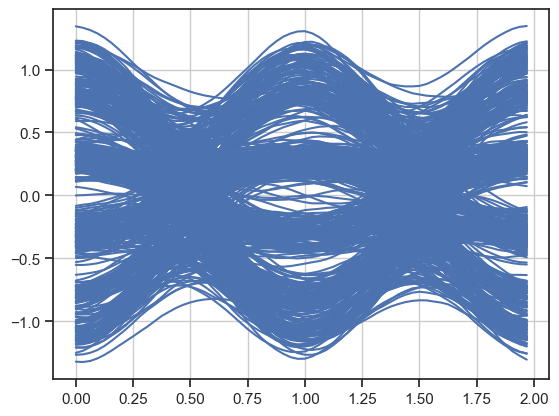

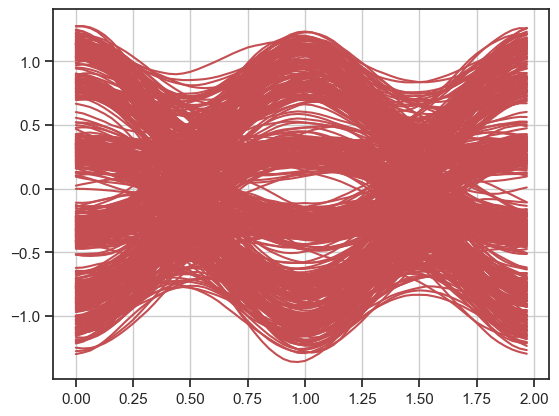

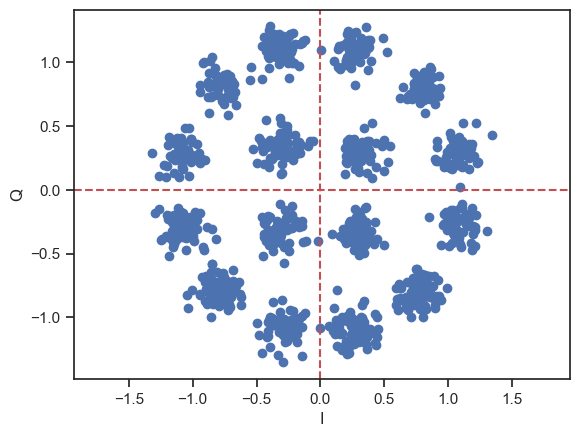

0.49267578125


In [234]:
# Arrays to store results for 16-APSK
ber_simulated = []
ser_nn = []
confidence_intervals = []
snr = []
calc_snr = 17.5
snr_db_low = calc_snr - 5
snr_db_high = calc_snr + 4
energy_efficiency = 1.185
for snr_db in np.arange(18,19,1):
    snr_linear = 10**(snr_db/10)
    ser_theory = ser_apsk_16_nn((energy_efficiency*snr_linear)/8)
    # print(ser_theory)
    ber_sim, s_c = montecarlo_16apsk(snr_linear)
    print(ber_sim)
    ser_nn.append(ser_theory)
    ber_simulated.append(ber_sim)
    confidence_intervals.append(s_c)
    snr.append(snr_db)

In [235]:
ber_simulated

[np.float64(0.49267578125)]

In [201]:
def int_to_bits(nn, K):
    """Convert an integer to a sequence of K bits (MSB) first"""
    # allocate memory for bits
    bits = np.zeros(K, dtype=np.uint8)
    
    # define the mask
    mask = 1 << (K-1)
    
    for k in range(K):
        # extract the current MSB and store it
        bits[k] = (nn & mask) >> (K-1)
        # shift the bits by one position
        nn = nn << 1
        
    return bits

In [202]:
def demodulator(syms, mod_table):
    """Recover bit sequence from received symbols"""
    # how many bits per symbol?
    K = int( np.log2(len(mod_table)) )
    
    # how many bits will we get?
    N = len(syms) * K
    bits = np.zeros(N, dtype=np.uint8)

    # put mod_table's symbol values and keys into a Numpy array
    alphabet = np.array(list(mod_table.values()))
    pattern = np.array(list(mod_table.keys()), dtype=int)
    
    # find the constellation point closest to received symbol
    for n in range(len(syms)):
        s = syms[n]
        ind = np.argmin(np.abs(alphabet - s))
        min_k = pattern[ind]
                        
        # the index of the closest symbol is integer `min_k`
        # convert that to a sequence of K bits
        bits[n*K : (n+1)*K] = int_to_bits(min_k, K)
        
    return bits
            

In [203]:
apsk16_mod_data = mod_mapper(bits_in,apsk16)

In [204]:
bits_out = demodulator(apsk16_mod_data,apsk16)

In [205]:
bits_out

array([1, 1, 0, ..., 0, 1, 0], dtype=uint8)

In [207]:
np.array_equal(bits_in, bits_out)

True